In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys 
sys.path.append("../")
from itertools import product
import glob
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
import torch

from dataset.load import LoadDataset
from dataset.utils import load_credentials
from utils.vis import thumb_grid
from utils.geojson import GeoJson
from clustering.dbscan import MultiFeatureDBSCAN
from clustering.embedding import WSL, VGG16
from clustering.validation import get_all_annotation, score

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

# Multifeature DBSCAN

In [3]:
params = {
    "dataset": LoadDataset("../data/paris_1000.h5"),
    "model": VGG16(-5),
    "weights": (0.33, 0.33, 1-2*0.33),
    #"weights": (0.5, 0.5, 0.0),
    #"weights": (1.0, 0.0, 0.0),
    "max_data": 500,
    "eps": 0.13,
    "min_samples": 2
}
model = MultiFeatureDBSCAN(**params)
model.fit()

Get data from hdfs5 file...
Images to embeddings...
Vectorization of tags...
Final training set: (500, 2) (500, 500) (500, 500)
Compute distance matrix of locations...
Compute distance matrix of embeddings...
Compute distance matrix of tags...
dist_matrix: 0.0 0.4960548678552854+-0.09064534362819504 0.8099350262939938
Training DBSCAN...
Result: 40 clusters
Counts: 2 5.425+-5.598604736896506 24


Silhouette 0.0374985674734292, Calinski 15.618704960953517


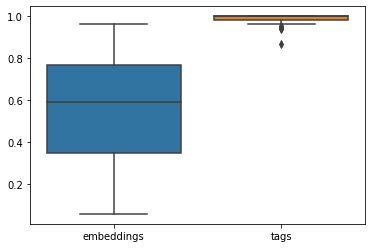

In [4]:
metrics = model.results()
print(f"Silhouette {metrics['sil']}, Calinski {metrics['cha']}")
df = pd.DataFrame({
    "embeddings": [metrics["embeddings_sims"][l] for l in metrics["embeddings_sims"].keys()],
    "tags": [metrics["tags_sims"][l] for l in metrics["tags_sims"].keys()]
})
sns.boxplot(data=df)

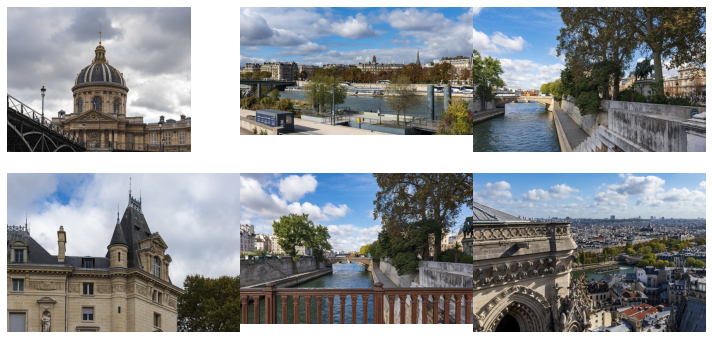

In [5]:
# Get images in clusters
cluster_imgs = {}
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    cluster_imgs[label] = []
    subset = np.random.choice(len(photos_id), size=min(len(photos_id), 6), replace=False)
    for photo_id in [photos_id[i] for i in subset]:
        _, img, _ = params["dataset"].get_id(int(photo_id))
        cluster_imgs[label].append(img)

# Visualize photos from the same cluster
cluster_label = 15
fig = thumb_grid(cluster_imgs[cluster_label], (2, 3))
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.show()
print(f"Embeddings sim: {metrics['embeddings_sims'][cluster_label]}, Tags sim: {metrics['tags_sims'][cluster_label]}")

In [6]:
pairs = [(model.idx[i], model.labels[i]) for i in range(model.labels.shape[0])]
GeoJson(params["dataset"], pairs).save_to("geojson-viewer/data.geojson")

# Validation

In [36]:
val_set_df = get_all_annotation(glob.glob("../data/annotations/annotations_*.csv"))
val_set = val_set_df.values.tolist()
score(model.labels, model.idx, val_set)

0.6556016597510373

# Grid Search

In [38]:
cnn_model = VGG16(-5)
dataset = LoadDataset("../data/paris_1000.h5")
max_data = 500
val_set = get_all_annotation(glob.glob("../data/annotations/annotations_*.csv")).values.tolist()

In [39]:
grid_params = [
    {"dataset": dataset, "model": cnn_model, "weights": (1.0, 0.0, 0.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.0, 1.0, 0.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.0, 0.0, 1.0), "max_data": max_data, "verbose": False},
    # {"dataset": dataset, "model": cnn_model, "weights": (0.33, 0.33, 1-2*0.33), "max_data": max_data, "verbose": False},
]

results = pd.DataFrame()
search_space = list(product(grid_params, np.arange(0.01, 0.20, 0.02), np.arange(2, 10, 1)))
print(f"Experiments: {len(search_space)}")
for i, candidate in enumerate(search_space):
    if i % 10 == 0: print(f"{i}/{len(search_space)}...")
    params, eps, min_samples = candidate
    params.update({"eps": eps, "min_samples": min_samples})
    model = MultiFeatureDBSCAN(**params)
    model.fit()
    metrics = model.results()
    metrics.update({
        "score": score(model.labels, model.idx, val_set),
    })
    metrics.update(params)
    results = results.append(metrics, ignore_index=True)

print("done")
results = results.drop(["dataset", "model"], axis=1)
results.sample(n=min(3, results.shape[0]))

Experiments: 80
0/80...
10/80...
20/80...
30/80...
40/80...
50/80...
60/80...
70/80...
done


,cha,embeddings_sims,eps,max_data,min_samples,n_clusters,score,sil,tags_sims,verbose,weights
41,291.683743,"{0: 0.32780674, 1: 0.003623628, 2: 0.100633636...",0.11,500.0,3.0,6.0,0.806228,0.639153,"{0: 0.23843738046275892, 1: 0.0083491155575506...",0.0,"(1.0, 0.0, 0.0)"
39,517.612758,"{0: 0.0036850092, 1: 0.100633636, 2: 0.18779312}",0.09,500.0,9.0,3.0,0.802092,0.692768,"{0: 0.008734851834901688, 1: 0.397717020736592...",0.0,"(1.0, 0.0, 0.0)"
77,18.470718,{0: 0.00054226513},0.19,500.0,7.0,1.0,0.806228,0.647563,{0: 0.00025816319107238285},0.0,"(1.0, 0.0, 0.0)"


In [40]:
results["embeddings_sims_mean"] = results["embeddings_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))
results["tags_sims_mean"] = results["tags_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))

best = results\
    .sort_values(by=["score", "n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    .groupby("weights").head(1)
best[["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "score", "n_clusters"]]

,weights,eps,min_samples,embeddings_sims_mean,tags_sims_mean,sil,score,n_clusters
0,"(1.0, 0.0, 0.0)",0.01,2.0,0.347162,0.617023,0.401847,0.820882,29.0


In [42]:
results[results["weights"] == (1.0, 0.0, 0.0)]\
    .sort_values(by=["score", "n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    [["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "n_clusters", "score"]].head(30)

,weights,eps,min_samples,embeddings_sims_mean,tags_sims_mean,sil,n_clusters,score
0,"(1.0, 0.0, 0.0)",0.01,2.0,0.347162,0.617023,0.401847,29.0,0.820882
1,"(1.0, 0.0, 0.0)",0.01,3.0,0.206793,0.537024,0.356156,20.0,0.819495
2,"(1.0, 0.0, 0.0)",0.01,4.0,0.145668,0.500259,0.333051,16.0,0.819495
7,"(1.0, 0.0, 0.0)",0.01,9.0,0.118180,0.438493,0.355015,14.0,0.818692
3,"(1.0, 0.0, 0.0)",0.01,5.0,0.137538,0.488472,0.315014,15.0,0.818100
4,"(1.0, 0.0, 0.0)",0.01,6.0,0.133057,0.468797,0.297976,14.0,0.813869
5,"(1.0, 0.0, 0.0)",0.01,7.0,0.122522,0.450344,0.320525,13.0,0.809568
6,"(1.0, 0.0, 0.0)",0.01,8.0,0.122522,0.450344,0.320525,13.0,0.809568
8,"(1.0, 0.0, 0.0)",0.03,2.0,0.341577,0.644923,0.330931,14.0,0.806228
16,"(1.0, 0.0, 0.0)",0.05,2.0,0.312518,0.577346,0.348261,12.0,0.806228
